In [1]:
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent

In [3]:
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

In [4]:
train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


In [5]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


# problem 1

In [9]:
from IPython.display import display, Image
display(Image(filename="notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

In [10]:
display(Image(filename="notMNIST_small/B/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))
display(Image(filename="notMNIST_small/C/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))
display(Image(filename="notMNIST_small/D/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))
display(Image(filename="notMNIST_small/J/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))

In [11]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825024
Standard deviation: 0.44312063
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.0075630303
Standard deviation: 0.45449105
Pickling .\notMNIST_large\C.pickle.
.\notMNIST_large\C
Full dataset tensor: (52912, 

# problem 2

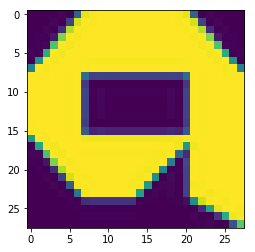

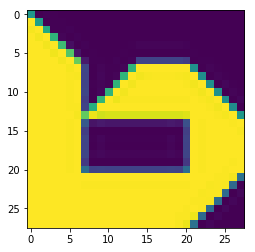

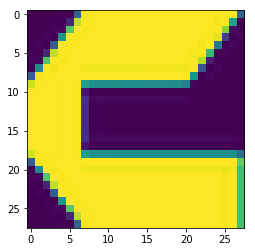

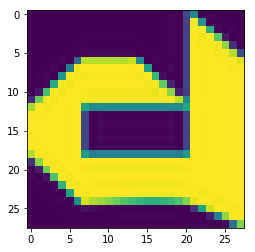

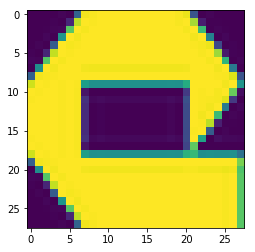

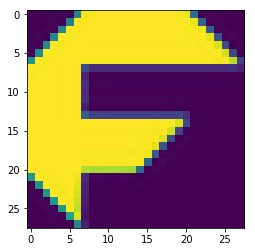

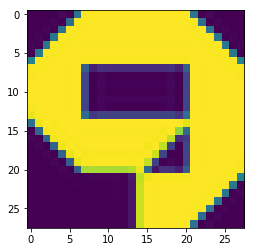

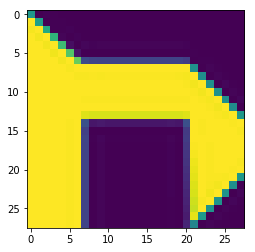

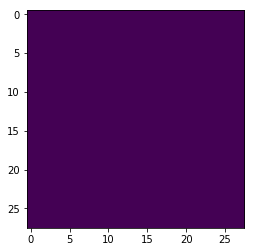

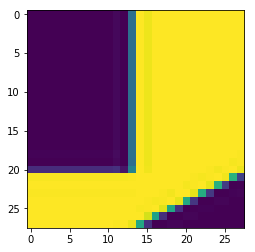

In [19]:
basedir = 'notMNIST_large'
for label in os.listdir(basedir):
    if 'pickle' not in label:
        continue
    dataset = pickle.load(open(basedir + '/' + label, "rb" ))
    plt.imshow(dataset[0])
    plt.show()

# problem 3

In [20]:
basedir = 'notMNIST_large'
for label in os.listdir(basedir):
    if 'pickle' not in label:
        continue
    dataset = pickle.load(open(basedir + '/' + label, "rb" ))
    print(label)
#     print(dataset.shape)
    print('Mean', dataset.mean())
    print('Std', dataset.std())
    print('-' * 20)

A.pickle
Mean -0.12825024
Std 0.44312063
--------------------
B.pickle
Mean -0.0075630303
Std 0.45449105
--------------------
C.pickle
Mean -0.14225811
Std 0.43980625
--------------------
D.pickle
Mean -0.057367794
Std 0.45564765
--------------------
E.pickle
Mean -0.06989899
Std 0.45294195
--------------------
F.pickle
Mean -0.1255833
Std 0.44708964
--------------------
G.pickle
Mean -0.09458135
Std 0.44623983
--------------------
H.pickle
Mean -0.06852206
Std 0.45423177
--------------------
I.pickle
Mean 0.03078625
Std 0.46889907
--------------------
J.pickle
Mean -0.15335836
Std 0.44365644
--------------------


In [21]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)           

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [22]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

# problem 4

In [23]:
print('Train mean', train_dataset.mean())
print('Train std', train_dataset.std())
print('-' * 20)

print('Test mean', test_dataset.mean())
print('Test std', test_dataset.std())
print('-' * 20)

print('Valid mean', valid_dataset.mean())
print('Valid std', valid_dataset.std())
print('-' * 20)

Train mean -0.081307955
Train std 0.45428205
--------------------
Test mean -0.07398297
Test std 0.45881662
--------------------
Valid mean -0.081459686
Valid std 0.45430106
--------------------


train


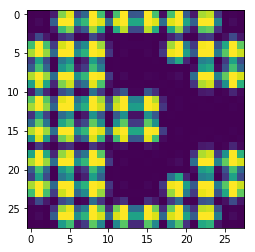

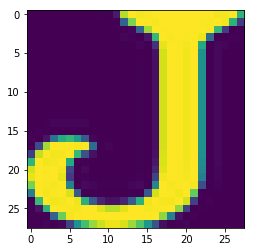

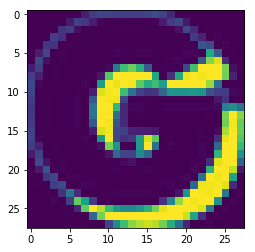

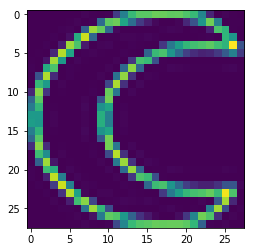

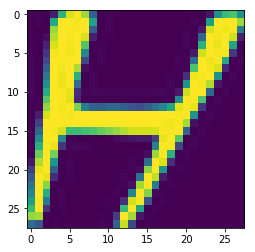

test


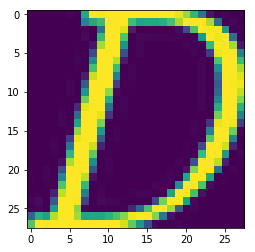

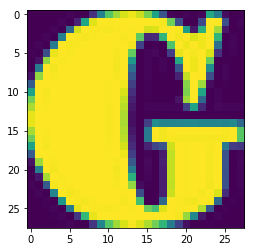

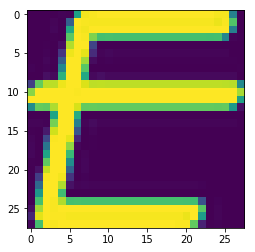

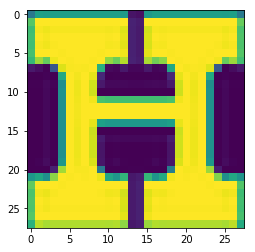

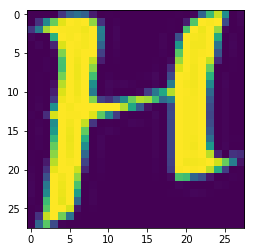

valid


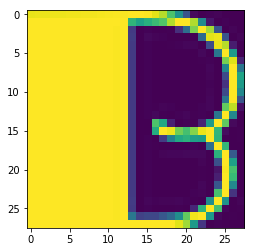

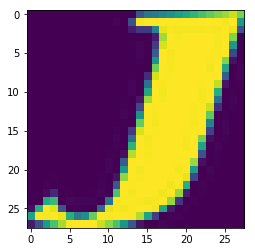

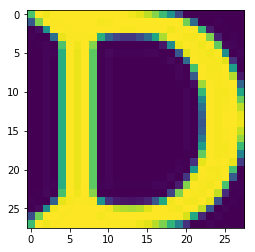

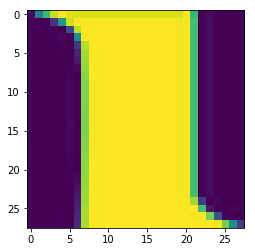

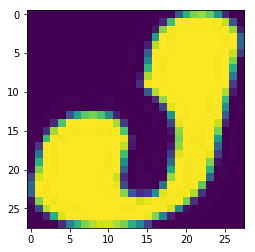

In [24]:
print('train')
for i in range(5):
    plt.imshow(train_dataset[i])
    plt.show()
    
print('test')
for i in range(5):
    plt.imshow(test_dataset[i])
    plt.show()
    
print('valid')
for i in range(5):
    plt.imshow(valid_dataset[i])
    plt.show()

In [25]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [26]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


# problem 5

In [27]:
def get_similarities_for_sets(setA, setB):
    lenA = len(setA)
    lenB = len(setB)
    
    vectorsA = setA.reshape(lenA, -1)
    vectorsB = setB.reshape(lenB, -1)
    
    numerator = vectorsA.dot(vectorsB.T)
    
    normsA = np.sqrt((vectorsA * vectorsA).sum(axis=1))
    normsB = np.sqrt((vectorsB * vectorsB).sum(axis=1))
    
    denominator = np.outer(normsA, normsB)
    
    result = numerator / denominator
    
    assert result.shape[0] == lenA
    assert result.shape[1] == lenB
    
    return result

In [28]:
def get_sanitized_dataset(A, Alabels, B, Blabels, threshold=1e-4):
    Aunique = np.ones_like(Alabels)
    
    for l in np.unique(Alabels):
        idxA = Alabels == l
        idxB = Blabels == l
        
        filteredA = A[idxA]
        filteredB = B[idxB]
        
        distances = 1. - get_similarities_for_sets(filteredA, filteredB)
        Adistances = distances.min(axis=1)
        
        Aunique[idxA] = Adistances > threshold
        
    return A[Aunique == 1], Alabels[Aunique == 1]

In [29]:

a, b = get_sanitized_dataset(valid_dataset, valid_labels, valid_dataset, valid_labels)
print(a.shape, b.shape)

(0, 28, 28) (0,)


In [30]:
Xtest_s, Ytest_s = get_sanitized_dataset(test_dataset, test_labels, valid_dataset, valid_labels)
print(Xtest_s.shape, Ytest_s.shape)

Xtest_s, Ytest_s = get_sanitized_dataset(Xtest_s, Ytest_s, train_dataset, train_labels)
print(Xtest_s.shape, Ytest_s.shape)

(9773, 28, 28) (9773,)
(8489, 28, 28) (8489,)


In [31]:
Xvalid_s, Yvalid_s = get_sanitized_dataset(valid_dataset, valid_labels, test_dataset, test_labels)
print(Xvalid_s.shape, Yvalid_s.shape)

Xvalid_s, Yvalid_s = get_sanitized_dataset(Xvalid_s, Yvalid_s, train_dataset, train_labels)
print(Xvalid_s.shape, Yvalid_s.shape)

(9822, 28, 28) (9822,)
(8742, 28, 28) (8742,)


In [32]:
Xtrain, Ytrain = train_dataset, train_labels


In [33]:
print('Train', Xtrain.shape, Ytrain.shape)
print('Valid', Xvalid_s.shape, Yvalid_s.shape)
print('Test', Xtest_s.shape, Ytest_s.shape)

Train (200000, 28, 28) (200000,)
Valid (8742, 28, 28) (8742,)
Test (8489, 28, 28) (8489,)


# problem 6

In [34]:
from sklearn.linear_model import LogisticRegression


In [ ]:
res = {}

for n in [50, 100, 1000, 5000, 10000, 50000]:
    clf = LogisticRegression(n_jobs=-1)
    clf.fit(Xtrain[:n].reshape(n, -1), Ytrain[:n])
    score = clf.score(Xtest_s.reshape(len(Xtest_s), -1), Ytest_s)
    
    res[n] = {'clf': clf, 'score': score}
    print(n, score)

C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: Fut

50 0.49405112498527504
100 0.6814701378254211


C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


1000 0.8182353634114736


C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


5000 0.836847685239722


C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Ravi Singh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [ ]:
keys = res.keys()
keys.sort()
plt.xscale('log')
plt.plot(keys, [res[k]['score'] for k in keys])

In [ ]:
i = np.random.randint(len(Xtest_s))
print('Ground truth class', Ytest_s[i])
for n in keys:
    print(n, res[k]['clf'].predict(Xtest_s[i].reshape(1, -1)))
plt.imshow(Xtest_s[i])